# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 6 Dynamic Risk Allocation Example
### David Lowe
### September 14, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the Dynamic Risk Allocation example found in chapter six of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sample GOOG stock data available with the book

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
# from pandas_datareader import data
import statistics as stats
import math as math

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
SYMBOL = 'GOOG'
SRC_DATA_FILENAME = SYMBOL + '_data.pkl'
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
APO_VALUE_FOR_BUY_ENTRY = -10  # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10  # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10  # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
# NUM_SHARES_PER_TRADE = 10  # Number of shares to buy/sell on every trade
# MIN_PROFIT_TO_CLOSE = 10 * NUM_SHARES_PER_TRADE  # Minimum Open/Unrealized profit at which to close positions and lock profits
MIN_NUM_SHARES_PER_TRADE = 1
MAX_NUM_SHARES_PER_TRADE = 50
INCREMENT_NUM_SHARES_PER_TRADE = 2
SMA_NUM_PERIODS = 20  # look back period

MODEL_START_DATE = date(2014, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2018, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

# Set Pandas dsiplay parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Starting date for the model: 2014-01-01
Ending date for the model: 2018-12-31


# Task 2 - Acquire and Pre-Process Data

In [3]:
# Fetch daily data for 4 years
data = pd.read_pickle(SRC_DATA_FILENAME)
print(data.head())

                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2014-01-02  555.647278  556.788025  552.060730  554.481689  554.481689  3656400
2014-01-03  555.418152  556.379578  550.401978  550.436829  550.436829  3345800
2014-01-06  554.426880  557.340942  551.154114  556.573853  556.573853  3551800
2014-01-07  560.399475  567.717041  558.486633  567.303589  567.303589  5124300
2014-01-08  570.860291  571.517822  564.528992  568.484192  568.484192  4501700


# Task 3 - Set up the Helper Functions for Modeling

In [4]:
# Not applicable for this iteration of modeling

# Task 4 - Build Model

In [5]:
# Variables/constants for EMA Calculation:
K_FAST = 2 / (NUM_PERIODS_FAST + 1)  # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = []  # we will hold fast EMA values for visualization purposes

K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)  # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = []  # we will hold slow EMA values for visualization purposes

apo_values = []  # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0  # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0  # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0  # Current position of the trading strategy
buy_sum_price_qty = 0  # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0  # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0  # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0  # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

num_shares_per_trade = MIN_NUM_SHARES_PER_TRADE  # Beginning number of shares to buy/sell on every trade
num_shares_history = [] # history of num-shares
abs_position_history = [] # history of absolute-position

# Constants/variables that are used to compute standard deviation as a volatility measure
price_history = []  # history of prices

In [6]:
# Risk limits and increments to risk limits when we have good/bad months
risk_limit_weekly_stop_loss = -6000
INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS = -12000
risk_limit_monthly_stop_loss = -15000
INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS = -30000
risk_limit_max_position = 5
INCREMENT_RISK_LIMIT_MAX_POSITION = 3
max_position_history = [] # history of max-trade-size
RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS = 120 * 5
risk_limit_max_trade_size = 5
INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE = 2
max_trade_size_history = [] # history of max-trade-size

risk_violated = False

traded_volume = 0
current_pos = 0
current_pos_start = 0
last_risk_change_index = 0

In [7]:
close = data['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS:  # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0  # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev / 15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if ema_fast == 0:  # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    if num_shares_per_trade > risk_limit_max_trade_size:
        print('RiskViolation num_shares_per_trade', num_shares_per_trade, ' > risk_limit_max_trade_size', risk_limit_max_trade_size )
        risk_violated = True

    MIN_PROFIT_TO_CLOSE = num_shares_per_trade * 10

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    if (not risk_violated and ((apo > APO_VALUE_FOR_SELL_ENTRY * stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  # APO above sell entry threshold, we should sell
        or (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  # long from -ve APO and APO has gone positive or position is profitable, sell to close position
        orders.append(-1)  # mark the sell trade
        last_sell_price = close_price
        if position == 0: # opening a new entry position
            position -= num_shares_per_trade  # reduce position by the size of this trade
            sell_sum_price_qty += (close_price * num_shares_per_trade)  # update vwap sell-price
            sell_sum_qty += num_shares_per_trade
            traded_volume += num_shares_per_trade
            print("Sell ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
        else: # closing an existing position
            sell_sum_price_qty += (close_price * abs(position))  # update vwap sell-price
            sell_sum_qty += abs(position)
            traded_volume += abs(position)
            print("Sell ", abs(position), " @ ", close_price, "Position: ", position)
            position = 0  # reduce position by the size of this trade

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    elif (not risk_violated and ((apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  # APO below buy entry threshold, we should buy
        or (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  # short from +ve APO and APO has gone negative or position is profitable, buy to close position
        orders.append(+1)  # mark the buy trade
        last_buy_price = close_price
        if position == 0: # opening a new entry position
            position += num_shares_per_trade  # increase position by the size of this trade
            buy_sum_price_qty += (close_price * num_shares_per_trade)  # update the vwap buy-price
            buy_sum_qty += num_shares_per_trade
            traded_volume += num_shares_per_trade
            print("Buy ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
        else: # closing an existing position
            buy_sum_price_qty += (close_price * abs(position))  # update the vwap buy-price
            buy_sum_qty += abs(position)
            traded_volume += abs(position)
            print("Buy ", abs(position), " @ ", close_price, "Position: ", position)
            position = 0  # increase position by the size of this trade
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # flat and starting a new position
    if current_pos == 0:
        if position != 0:
            current_pos = position
            current_pos_start = len(positions)
    # going from long position to flat or short position or
    # going from short position to flat or long position
    elif current_pos * position <= 0:
        current_pos = position
        position_holding_time = len(positions) - current_pos_start
        current_pos_start = len(positions)

        if position_holding_time > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS:
            print('RiskViolation position_holding_time', position_holding_time, ' > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS', RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS)
            risk_violated = True

    if abs(position) > risk_limit_max_position:
        print('RiskViolation position', position, ' > risk_limit_max_position', risk_limit_max_position)
        risk_violated = True

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0:  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0:  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
    pnls.append(closed_pnl + open_pnl)

    # Analyze monthly performance and adjust risk up/down
    if len(pnls) > 20:
        monthly_pnls = pnls[-1] - pnls[-20]

        if len(pnls) - last_risk_change_index > 20:
            if monthly_pnls > 0:
                num_shares_per_trade += INCREMENT_NUM_SHARES_PER_TRADE
                if num_shares_per_trade <= MAX_NUM_SHARES_PER_TRADE:
                    print('Increasing trade-size and risk')
                    risk_limit_weekly_stop_loss += INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS
                    risk_limit_monthly_stop_loss += INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS
                    risk_limit_max_position += INCREMENT_RISK_LIMIT_MAX_POSITION
                    risk_limit_max_trade_size += INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE
                else:
                    num_shares_per_trade = MAX_NUM_SHARES_PER_TRADE
            elif monthly_pnls < 0:
                num_shares_per_trade -= INCREMENT_NUM_SHARES_PER_TRADE
                if num_shares_per_trade >= MIN_NUM_SHARES_PER_TRADE:
                    print('Decreasing trade-size and risk')
                    risk_limit_weekly_stop_loss -= INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS
                    risk_limit_monthly_stop_loss -= INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS
                    risk_limit_max_position -= INCREMENT_RISK_LIMIT_MAX_POSITION
                    risk_limit_max_trade_size -= INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE
                else:
                    num_shares_per_trade = MIN_NUM_SHARES_PER_TRADE

            last_risk_change_index = len(pnls)

    # Track trade-sizes/positions and risk limits as they evolve over time
    num_shares_history.append(num_shares_per_trade)
    abs_position_history.append(abs(position))
    max_trade_size_history.append(risk_limit_max_trade_size)
    max_position_history.append(risk_limit_max_position)

    if len(pnls) > 5:
        weekly_loss = pnls[-1] - pnls[-6]

        if weekly_loss < risk_limit_weekly_stop_loss:
            print('RiskViolation weekly_loss', weekly_loss, ' < risk_limit_weekly_stop_loss', risk_limit_weekly_stop_loss)
            risk_violated = True

    if len(pnls) > 20:
        monthly_loss = pnls[-1] - pnls[-21]

        if monthly_loss < risk_limit_monthly_stop_loss:
            print('RiskViolation monthly_loss', monthly_loss, ' < risk_limit_monthly_stop_loss', risk_limit_monthly_stop_loss)
            risk_violated = True

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  1  @  573.116821 Position:  -1
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  1  @  579.677246 Position:  -1
OpenPnL:  0  ClosedPnL:  1152.7940669999998  TotalPnL:  1152.7940669999998
Sell  1  @  580.334778 Position:  -1
OpenPnL:  0.0  ClosedPnL:  1152.7940669999998  TotalPnL:  1152.7940669999998
OpenPnL:  2.450806000000057  ClosedPnL:  1152.7940669999998  TotalPnL:  1155.2448729999999
Sell  1  @  559.81665 Position:  -1
OpenPnL:  0  ClosedPnL:  2292.945495  TotalPnL:  2292.945495
OpenPnL:  0  ClosedPnL:  2292.945495  TotalPnL:  2292

In [8]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))
data = data.assign(NumShares=pd.Series(num_shares_history, index=data.index))
data = data.assign(MaxTradeSize=pd.Series(max_trade_size_history, index=data.index))
data = data.assign(AbsPosition=pd.Series(abs_position_history, index=data.index))
data = data.assign(MaxPosition=pd.Series(max_position_history, index=data.index))

print(data.head())

                  Open        High         Low       Close   Adj Close   Volume  ClosePrice  Fast10DayEMA  Slow40DayEMA       APO  Trades  Position  Pnl  NumShares  MaxTradeSize  AbsPosition  MaxPosition
Date                                                                                                                                                                                                       
2014-01-02  555.647278  556.788025  552.060730  554.481689  554.481689  3656400  554.481689    554.481689    554.481689  0.000000       0         0  0.0          1             5            0            5
2014-01-03  555.418152  556.379578  550.401978  550.436829  550.436829  3345800  550.436829    554.382532    554.455086 -0.072554       0         0  0.0          1             5            0            5
2014-01-06  554.426880  557.340942  551.154114  556.573853  556.573853  3551800  556.573853    554.450194    554.472638 -0.022444       0         0  0.0          1             5       

# Task 5 - Evaluate Model Performance

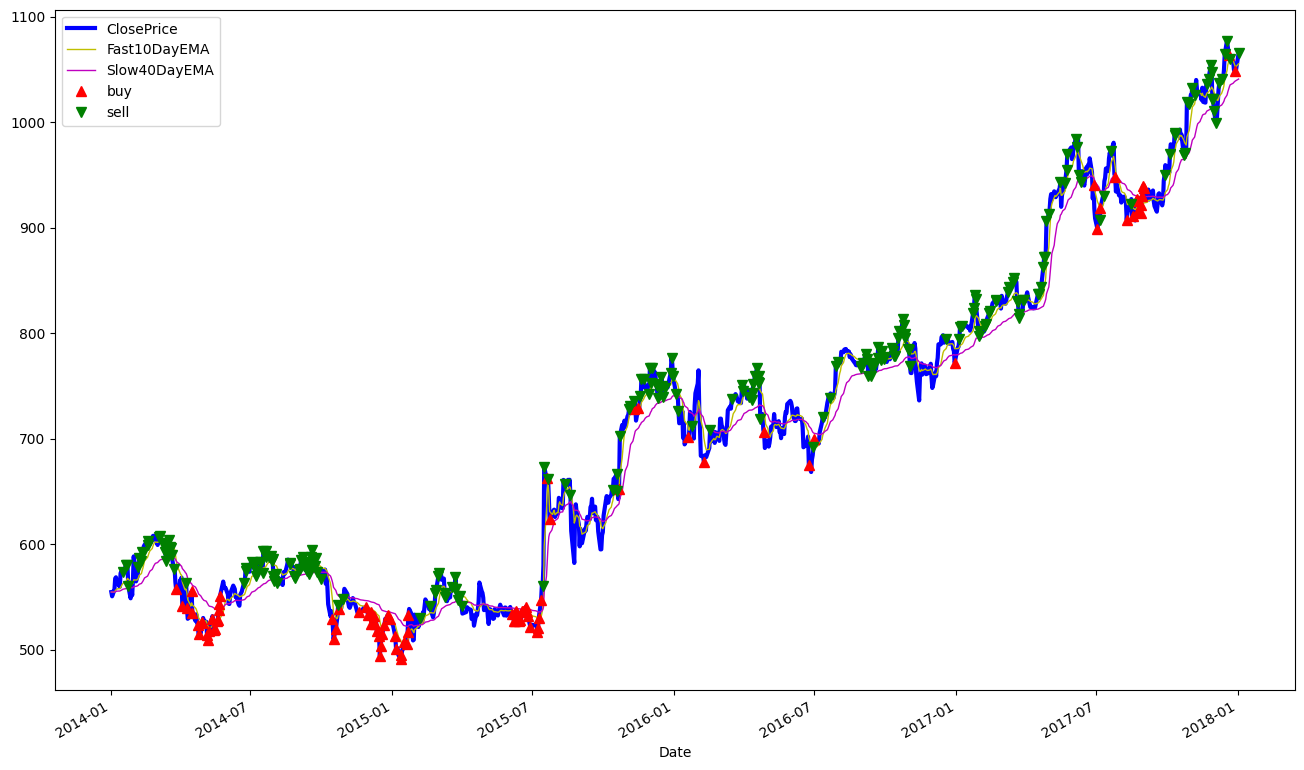

In [9]:
plt.figure(figsize=(16,10))
data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

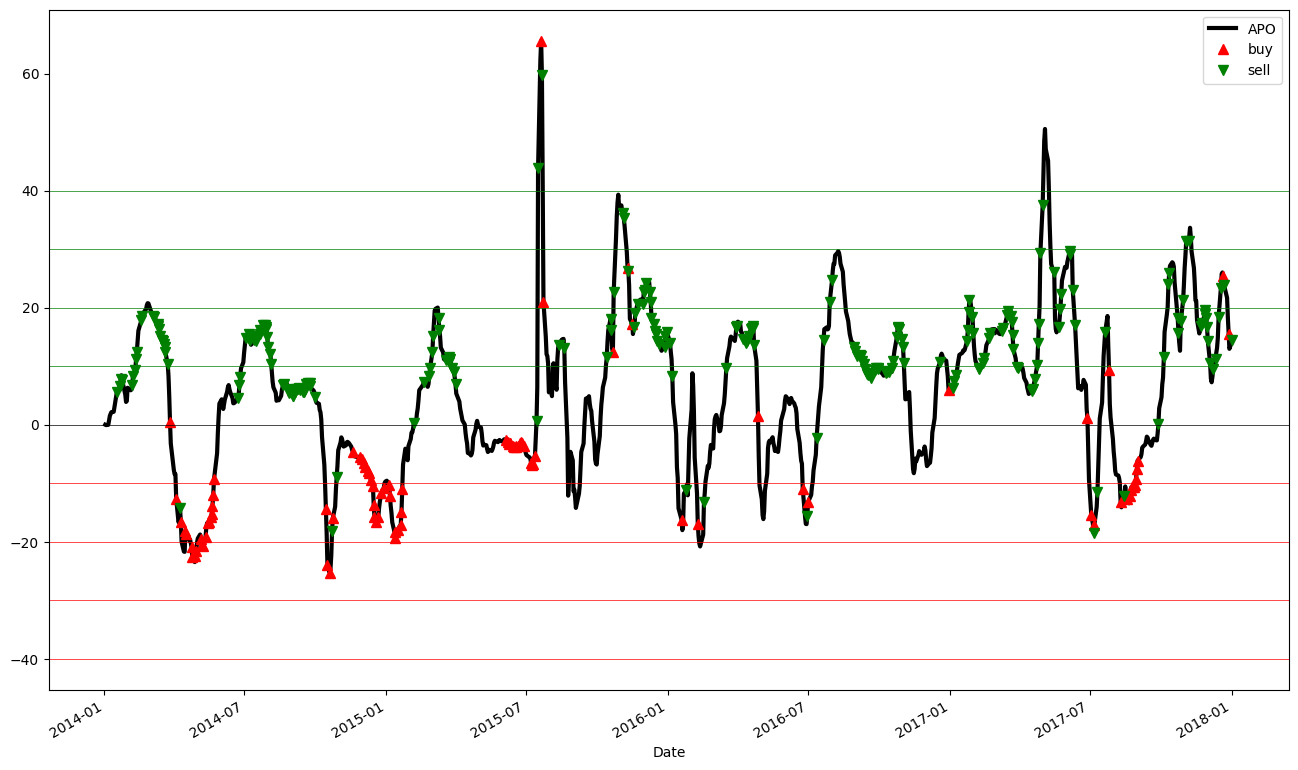

In [10]:
plt.figure(figsize=(16,10))
data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

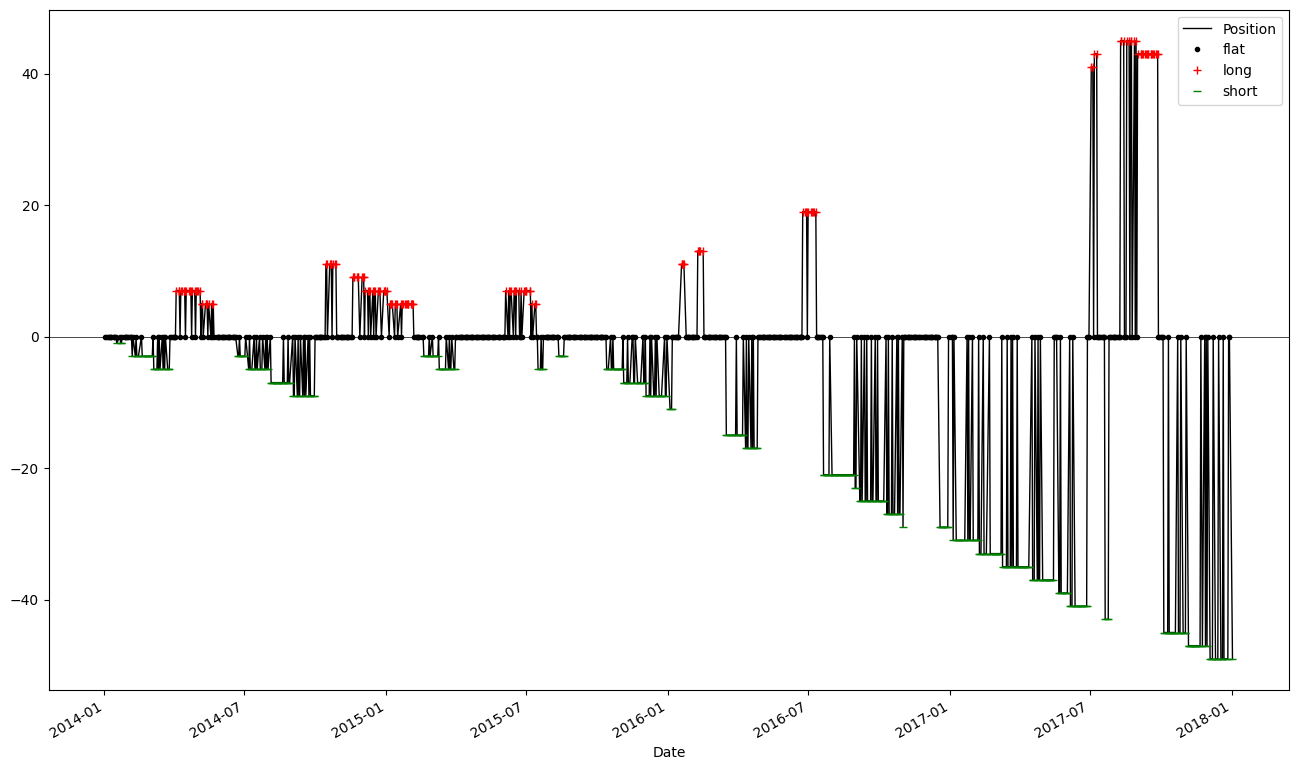

In [11]:
plt.figure(figsize=(16,10))
data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
plt.legend()
plt.show()

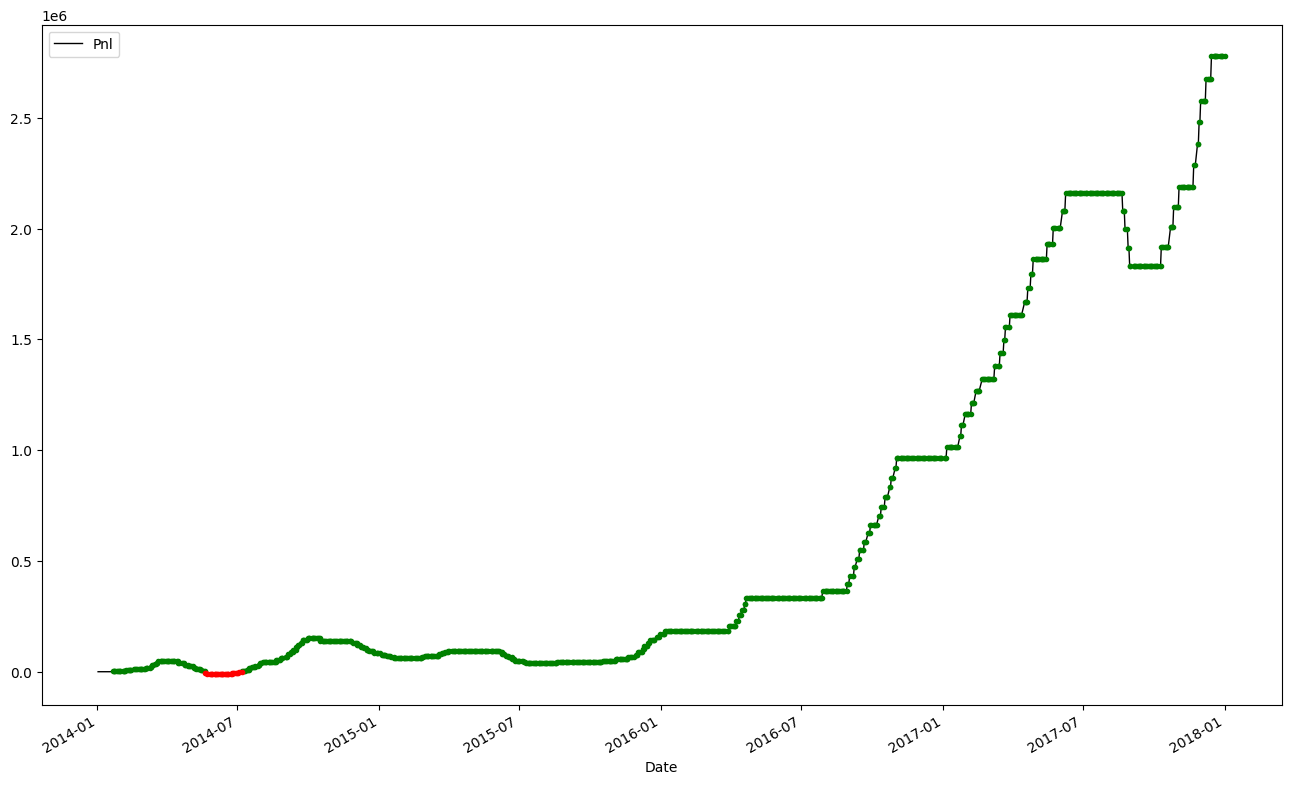

In [12]:
plt.figure(figsize=(16,10))
data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

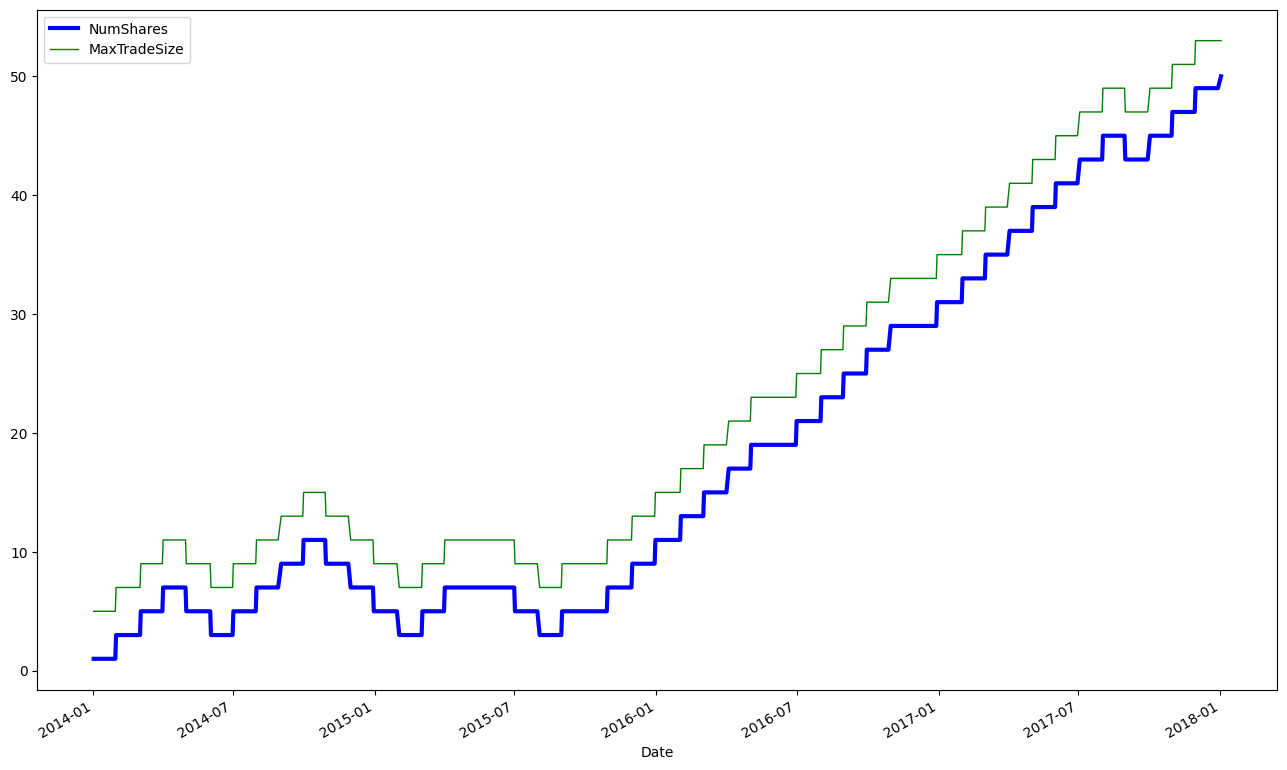

In [13]:
plt.figure(figsize=(16,10))
data['NumShares'].plot(color='b', lw=3., legend=True)
data['MaxTradeSize'].plot(color='g', lw=1., legend=True)
plt.legend()
plt.show()

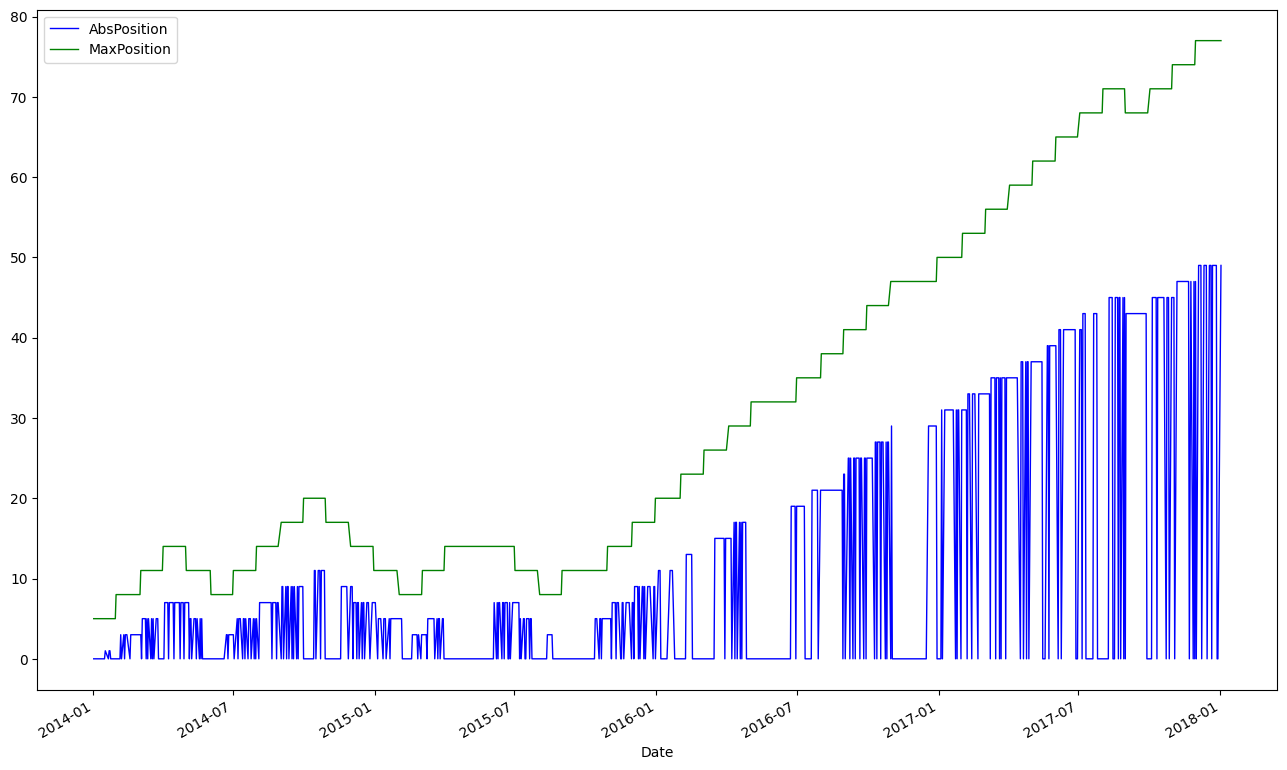

In [14]:
plt.figure(figsize=(16,10))
data['AbsPosition'].plot(color='b', lw=1., legend=True)
data['MaxPosition'].plot(color='g', lw=1., legend=True)
plt.legend()
plt.show()